In [13]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

IMAGE_SIZE = 128
BATCH_SIZE = 32
DATA_DIR = "Chest_xray"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("✅ Classes:", train_dataset.classes)

✅ Classes: ['NORMAL', 'PNEUMONIA']


#### Class Distrubution (Train Set)

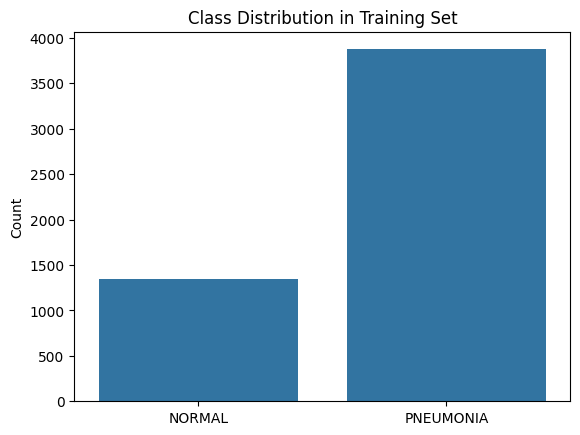

In [17]:
from collections import Counter

labels = [label for _ , label in train_dataset]
label_counts = Counter(labels)
sns.barplot(x=[train_dataset.classes[i] for i in label_counts.keys()],
            y=list(label_counts.values()))
plt.title("Class Distribution in Training Set")
plt.ylabel("Count")
plt.show()

#### Visualize Sample Images

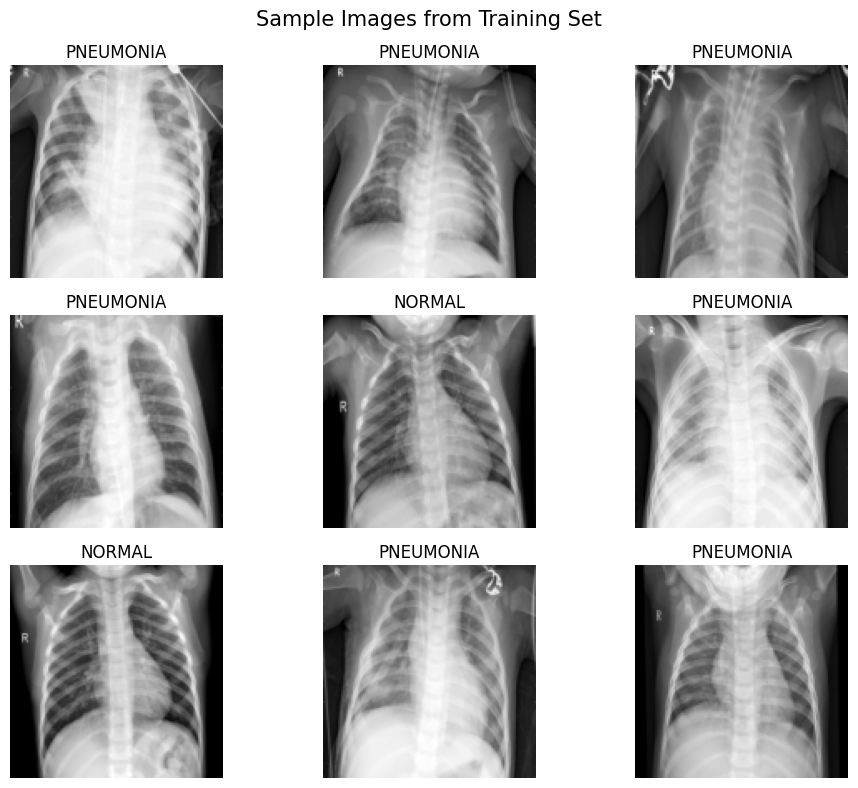

In [22]:
def show_batch(dl, class_names):
    images, labels = next(iter(dl))
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].squeeze(0)
        ax.imshow(img, cmap="gray")
        ax.set_title(class_names[labels[i].item()])
        ax.axis("off")
    plt.suptitle("Sample Images from Training Set", fontsize=15)
    plt.tight_layout()
    plt.show()

show_batch(train_loader, train_dataset.classes)

#### Define CNN Architecture in PyTorch

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.sigmoid(x)

#### Input Assumptions:
Grayscale images resized to 150 * 150

#### Model Training Setup in PyTorch

In [46]:
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = PneumoniaCNN().to(device)

# Handel class imbalance: calculate weigts
from collections import Counter
labels = [label for _, label in train_dataset]
class_counts = Counter(labels)
total = sum(class_counts.values())
weights = [total / class_counts[i] for i in range(2)]

# Define loss with class weights
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.BCELoss(reduction="none")

# Optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 patience=2, factor=0.5)

#### Basic Training Loop Template

In [47]:
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        weighted_loss = (loss * labels * class_weights[1] + loss * (1 - labels) *
                        class_weights[0]).mean()
        weighted_loss.backward()
        optimizer.step()

        total_loss += weighted_loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

#### Define Validation Loop

In [48]:
def validate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            weighted_loss = (loss * labels * class_weights[1] + 
                             loss * (1 - labels) * class_weights[0]).mean()
            
            total_loss += weighted_loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
    
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

#### Run Epochs with Training + Validation

In [49]:
NUM_EPOCHS = 3
best_val_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Adjust learning rate
    scheduler.step(val_acc)
    print(f"Epoch {epoch}/{NUM_EPOCHS} "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best model
    if val_acc >best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cnn_model.pth")
    
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 1/3 Train Loss: 0.2997, Acc: 0.9442 Val Loss: 2.0883, Acc: 0.7500
Best Validation Accuracy: 0.7500
Epoch 2/3 Train Loss: 0.1686, Acc: 0.9699 Val Loss: 0.3506, Acc: 0.9375
Best Validation Accuracy: 0.9375
Epoch 3/3 Train Loss: 0.1217, Acc: 0.9758 Val Loss: 1.9506, Acc: 0.6875
Best Validation Accuracy: 0.9375
